In [520]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

from sklearn import svm,tree
from sklearn.externals.six import StringIO  
import pydot

In [351]:
df = pd.read_csv('../data/aden_golfe_matrix_area.csv',sep=';')

# Pre-traitement

### Attack column

On créé une colonne pour savoir si il y a une attaque ou non.

In [580]:
def bool_attack(count):
    if count>0:
        return 1
    else:
        return 0

df['attack'] = df.apply(lambda row: bool_attack(row['count']), axis=1)

### Binary

Le but de ce paragraphe est de transformer les colonnes "lat_area" et "lon_area" en colonnes binaire, c'est à dire de créer autant de colonnes que d'observations possibles

On créer les colonnes vides

In [581]:
feature_dyna=[]

latUnique=np.sort(df['lat_area'].unique())
print latUnique
for i in range(0,len(latUnique)):
    nameColLat='lat_area_'+str(latUnique[i])
    #print nameColLat
    df[nameColLat]=0
    feature_dyna.append(nameColLat)
    
lonUnique=np.sort(df['lon_area'].unique())
print lonUnique
for i in range(0,len(lonUnique)):
    nameColLon='lon_area_'+str(lonUnique[i])
    #print nameColLon
    df[nameColLon]=0
    feature_dyna.append(nameColLon)

[ 1  2  3  4  5  6  7  8  9 10]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28]


On remplit ensuite les colonnes 'lat_area_ ...' et 'lon_area_ ...'

In [582]:
for index, row in df.iterrows():
    df.set_value(index, "lat_area_"+str(row['lat_area']),1)
    df.set_value(index, "lon_area_"+str(row['lon_area']),1)
        
    
df.head()

,Month,Years,count,lat_area,lon_area,attack,lat_area_1,lat_area_2,lat_area_3,lat_area_4,...,lon_area_19,lon_area_20,lon_area_21,lon_area_22,lon_area_23,lon_area_24,lon_area_25,lon_area_26,lon_area_27,lon_area_28
0,1,2008,0,8,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2008,0,9,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2008,0,6,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2008,0,7,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2008,0,8,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Sampling 

In [618]:
globalfeatures=['Month','Years']

features=np.concatenate([np.asarray(feature_dyna),globalfeatures])
features2=np.concatenate([globalfeatures,['lat_area','lon_area']])

#print features
#print features2

target='attack'

In [619]:
df_attack_raw = df[df[target] == 1]
df_non_attack_raw = df[df[target] == 0]
percentage = len(df_attack_raw)/float(len(df_non_attack_raw))
print percentage
df_non_attack=df.sample(frac=percentage)
print str(len(df_non_attack))+'/'+str(len(df_non_attack_raw))

DfSampling=df_non_attack.append(df_attack_raw)
print len(DfSampling)

0.0488807674737
337/6567
658


# Algorithme de machine learning

## Séparation des jeux de données

On définit un jeu de données pour entrainer notre modèle et un jeu de données pour tester et évaluer notre modèle.

In [620]:
years_prediction=2012
dfTrain=DfSampling[DfSampling['Years']<years_prediction]
dfTest=DfSampling[(DfSampling['Years']==years_prediction)]

print "Année à prédire : "+str(years_prediction)
print " "
print "Entrainement : Nombre d'attaques /nombre de ligne : "+str(len(dfTrain[dfTrain['count']!=0]))+'/'+str(len(dfTrain))
print "Test : Nombre d'attaques /nombre de ligne : "+str(len(dfTest[dfTest['count']!=0]))+'/'+str(len(dfTest))

Année à prédire : 2012
 
Entrainement : Nombre d'attaques /nombre de ligne : 296/468
Test : Nombre d'attaques /nombre de ligne : 25/59


## Random forest

On définit les colonnes pour prédire les attaques.

In [622]:
forest = RandomForestClassifier(random_state=1,n_estimators=20)
forest=forest.fit(dfTrain[features], dfTrain[target])

predictions=forest.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['count']!=0]))

print "Pourcentage de précision : "+str(forest.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictions)

Nombre d'attaques prévus/Nombre d'attaques réel: 30/25
Pourcentage de précision : 0.64406779661


In [623]:
#print pd.crosstab(dfTest[target],predictions, colnames=['preds'])
pd.crosstab(dfTest[target],predictions, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

preds,0,1
attack,,
0,0.617647,0.382353
1,0.320000,0.680000


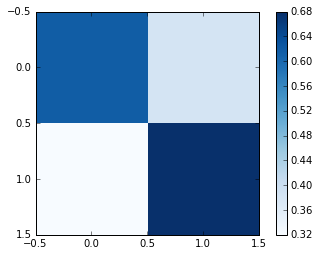

In [624]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Compare area

In [625]:
dfTest['prediction']=predictions
Compare=dfTest[(dfTest[target]!=0) | (dfTest['prediction']!=0)].sort(['Years','Month','lat_area','lon_area'])
Compare[['Month','Years','lat_area','lon_area','attack','prediction']]

/Users/romainphilippe/app/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/romainphilippe/app/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Month,Years,lat_area,lon_area,attack,prediction
3947,1,2012,3,6,0,1
3949,1,2012,3,7,1,1
3968,1,2012,4,15,0,1
3971,1,2012,4,16,1,1
3945,1,2012,5,5,1,1
4014,1,2012,5,28,1,1
4029,2,2012,3,6,1,1
4026,2,2012,4,5,1,1
4030,2,2012,4,6,1,1
4068,2,2012,4,20,0,1


# Boosting 

In [571]:


boos = GradientBoostingClassifier(random_state=1,n_estimators=100,max_depth=10)
boos=boos.fit(dfTrain[features], dfTrain[target])

predictionsBoos=boos.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictionsBoos.sum())+'/'+str(len(dfTest[dfTest['count']!=0]))

print "Pourcentage de précision : "+str(boos.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictionsBoos)

Nombre d'attaques prévus/Nombre d'attaques réel: 51/25
Pourcentage de précision : 0.538461538462


In [626]:
#print pd.crosstab(dfTest[target],predictions, colnames=['preds'])
pd.crosstab(dfTest[target],predictionsBoos, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

ValueError: array length 78 does not match index length 59